# Prediction by Ichimoku Cloud

In [1]:
import pandas as pd
df = pd.read_csv('BTC_data_with_ichimoku.csv')
df.sort_index(ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [2]:
df.rename(columns={
    'ich_base_line': 'BaseLine',
    'ich_conv_line': 'ConvLine',
    'ich_span_a': 'SpanA',
    'ich_span_b': 'SpanB'
}, inplace=True)

Let's save the df in two types:

In [3]:
df.Date = pd.to_datetime(df.Date)

dfTS = df.set_index(df.Date)
dfTS.drop(['Date'], axis=1, inplace=True)

## Is Ichmoku Indicator Data Accurate?

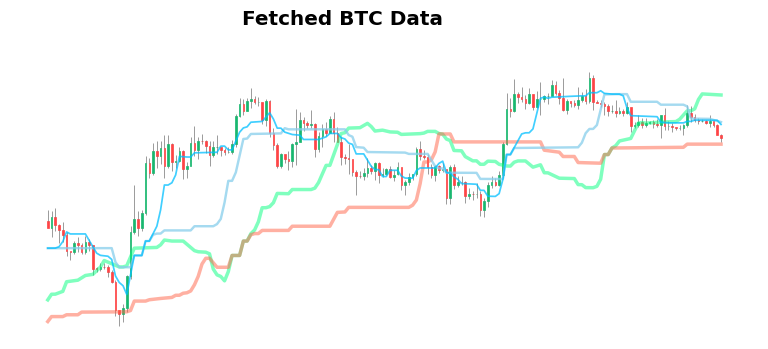

In [4]:
import mplfinance as mpf
import matplotlib.pyplot as plt

df_90_days = dfTS.iloc[:180, :].sort_index(ascending=True)

def ichimoku_btc_chart_60days(fs1, fs2):
    cloud_color = mpf.make_marketcolors(up='g', down='r', inherit=True)

    # Ichimoku data
    ichimoku = [
        mpf.make_addplot(df_90_days['SpanA'], color='springgreen',width=2.5, alpha=0.5),
        mpf.make_addplot(df_90_days['SpanB'], color='tomato',width=2.5, alpha=0.5),
        mpf.make_addplot(df_90_days['BaseLine'], color='skyblue', width=1.75, alpha=0.75),
        mpf.make_addplot(df_90_days['ConvLine'], color='deepskyblue', width=1.25, alpha=0.75)
    ]

    # Draw the graph
    mpf.plot(
        df_90_days, 
        type='candle', 
        addplot=ichimoku, 
        style='yahoo', 
        figsize = (fs1,fs2),
        title = 'Fetched BTC Data',
        axisoff=True
    )



ichimoku_btc_chart_60days(10.4,4)

**_TradingView Data_**

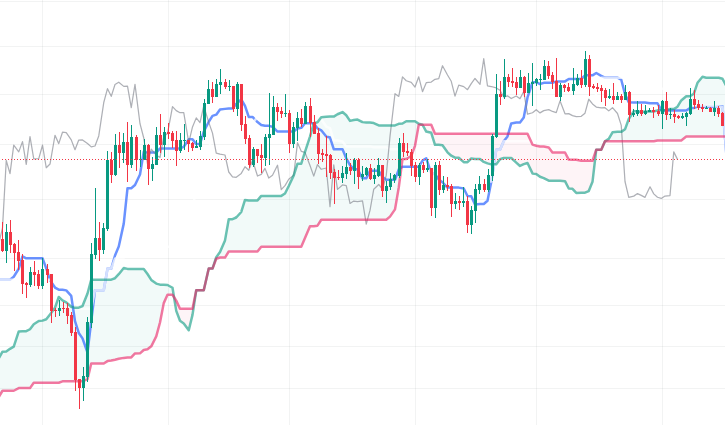

## Make the dataset with Ichimoku signals that'll be put into model

In [5]:
# Price/Cloud Position
for i in range(len(df)):
    
    if ((df.loc[i, 'Close'] < df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] < df.loc[i, 'SpanB'])): df.loc[i, 'PriceUnderCloud'] = 1
    else: df.loc[i, 'PriceUnderCloud'] = 0

    if (((df.loc[i, 'Close']>= df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] <= df.loc[i, 'SpanB'])) | ((df.loc[i, 'Close'] <= df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] >= df.loc[i, 'SpanB']))): df.loc[i, 'PriceInCloud'] = 1
    else: df.loc[i, 'PriceInCloud'] = 0
    
    if ((df.loc[i, 'Close'] > df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] > df.loc[i, 'SpanB'])): df.loc[i, 'PriceOverCloud'] = 1
    else: df.loc[i, 'PriceOverCloud'] = 0

# Price/Cloud Intersect
for i in range(len(df) - 1):
               
    if ((df.loc[i, 'PriceUnderCloud'] == 1) & ((df.loc[i+1, 'PriceOverCloud'] == 1) | (df.loc[i+1, 'PriceInCloud'] == 1))): df.loc[i, 'PriceCloudIntersectBear'] = 1
    else: df.loc[i, 'PriceCloudIntersectBear'] = 0

    if ((df.loc[i, 'PriceOverCloud'] == 1) & ((df.loc[i+1, 'PriceUnderCloud'] == 1) | (df.loc[i+1, 'PriceInCloud'] == 1))): 
        df.loc[i, 'PriceCloudIntersectBull'] = 1
    else: df.loc[i, 'PriceCloudIntersectBull'] = 0

In [6]:
for i in range(len(df)):

    # Price/BaseLine and Price/ConvLine Position (Under or Over)
    if df.loc[i,'Close'] >= df.loc[i, 'BaseLine']: df.loc[i, 'PriceBaseLinePosition'] = 1
    else: df.loc[i, 'PriceBaseLinePosition'] = 0

    if df.loc[i,'Close'] >= df.loc[i, 'ConvLine']: df.loc[i, 'PriceConvLinePosition'] = 1
    else: df.loc[i, 'PriceConvLinePosition'] = 0

    # Price/BaseLine and Price/ConvLine Distance
    df.loc[i, 'PriceBaseLineDistance'] = df.loc[i, 'Close'] - df.loc[i, 'BaseLine']
    df.loc[i, 'PriceConvLineDistance'] = df.loc[i, 'Close'] - df.loc[i, 'ConvLine']

    # ConvLine/BaseLine Position

    if df.loc[i, 'ConvLine'] >= df.loc[i, 'BaseLine']: df.loc[i, 'ConvLineBaseLinePosition'] = 1
    else: df.loc[i, 'ConvLineBaseLinePosition'] = 0

 
# ConvLine/BaseLine Inersect
for i in range(len(df)-1):
    if ((df.loc[i, 'ConvLineBaseLinePosition'] == 1) & (df.loc[i+1, 'ConvLineBaseLinePosition'] == 0)): df.loc[i, 'ConvBaseIntersectBull'] = 1
    else: df.loc[i, 'ConvBaseIntersectBull'] = 0

    if ((df.loc[i, 'ConvLineBaseLinePosition'] == 0) & (df.loc[i+1, 'ConvLineBaseLinePosition'] == 1)): df.loc[i, 'ConvBaseIntersectBear'] = 1
    else: df.loc[i, 'ConvBaseIntersectBear'] = 0

In [7]:
# Forward Cloud Width (Scaler)
break_check = False

for i in range(len(df)):
    # span A
    spanA = (df.loc[i, 'ConvLine'] + df.loc[i, 'BaseLine']) / 2

    sum_price_last_52_days = 0
    if i + 52 <= len(df):
        for j in range(52):
                sum_price_last_52_days += df.loc[i+j, 'Close']
                spanB = sum_price_last_52_days / 52 
                cloud_width = spanA - spanB
                df.loc[i, 'ForwardCloudWidth'] = cloud_width
    else: break
            


# Forward Cloud Intersect (Encder)

for i in range(len(df)-52):
    if ((df.loc[i, 'ForwardCloudWidth'] <= 0) & (df.loc[i+1, 'ForwardCloudWidth'] > 0)): df.loc[i, 'ForwardCloudIntersectBear'] = 1
    else: df.loc[i, 'ForwardCloudIntersectBear'] = 0
    
    if ((df.loc[i, 'ForwardCloudWidth'] >= 0) & (df.loc[i+1, 'ForwardCloudWidth'] < 0)): df.loc[i, 'ForwardCloudIntersectBull'] = 1
    else: df.loc[i, 'ForwardCloudIntersectBull'] = 0

In [8]:
df.dropna(axis = 0, inplace=True)

df.iloc[150:160,:]

,Date,Close,Open,High,Low,Vol,Change,BaseLine,ConvLine,SpanA,...,PriceBaseLinePosition,PriceConvLinePosition,PriceBaseLineDistance,PriceConvLineDistance,ConvLineBaseLinePosition,ConvBaseIntersectBull,ConvBaseIntersectBear,ForwardCloudWidth,ForwardCloudIntersectBear,ForwardCloudIntersectBull
150,2023-03-20,27720.5,27958.9,28457.8,27157.0,503900.0,-0.85,24024.80,24376.00,23362.125,...,1.0,1.0,3695.70,3344.50,1.0,0.0,0.0,805.048077,0.0,0.0
151,2023-03-19,27958.7,26914.5,28347.3,26844.6,393270.0,3.88,23969.55,24072.00,23327.750,...,1.0,1.0,3989.15,3886.70,1.0,0.0,0.0,714.767308,0.0,0.0
152,2023-03-18,26914.5,27391.9,27659.1,26688.7,392470.0,-1.74,23667.00,23667.00,23326.250,...,1.0,1.0,3247.50,3247.50,1.0,0.0,0.0,456.044231,0.0,0.0
153,2023-03-17,27391.8,25004.4,27742.2,24900.1,674960.0,9.55,23667.00,23667.00,23326.250,...,1.0,1.0,3724.80,3724.80,1.0,0.0,0.0,530.263462,0.0,1.0
154,2023-03-16,25004.1,24283.2,25139.0,24147.9,462580.0,2.97,22978.85,22978.85,23326.250,...,1.0,1.0,2025.25,2025.25,1.0,0.0,0.0,-66.361538,0.0,0.0
155,2023-03-15,24282.7,24699.6,25108.9,23932.4,614310.0,-1.69,22978.85,22978.85,23326.250,...,1.0,1.0,1303.85,1303.85,1.0,0.0,0.0,-26.196154,1.0,0.0
156,2023-03-14,24699.7,24121.5,26365.9,23994.6,753060.0,2.43,22978.85,22978.85,23326.250,...,1.0,1.0,1720.85,1720.85,1.0,1.0,0.0,4.090385,0.0,1.0
157,2023-03-13,24114.4,21994.8,24406.2,21859.6,733630.0,9.64,22414.30,21999.00,22874.800,...,1.0,1.0,1700.10,2115.40,0.0,0.0,0.0,-731.109615,0.0,0.0
158,2023-03-12,21994.8,20465.0,22028.6,20294.2,455690.0,7.46,22414.30,21114.25,22482.575,...,0.0,1.0,-419.50,880.55,0.0,0.0,0.0,-1145.846154,0.0,0.0
159,2023-03-11,20467.5,20156.5,20669.5,19796.7,453460.0,1.54,22414.30,21532.60,22430.175,...,0.0,0.0,-1946.80,-1065.10,0.0,0.0,0.0,-919.101923,0.0,0.0


## Data Preprocess

In [9]:
pd.Series(df.columns.tolist())

0                          Date
1                         Close
2                          Open
3                          High
4                           Low
5                           Vol
6                        Change
7                      BaseLine
8                      ConvLine
9                         SpanA
10                        SpanB
11              PriceUnderCloud
12                 PriceInCloud
13               PriceOverCloud
14      PriceCloudIntersectBear
15      PriceCloudIntersectBull
16        PriceBaseLinePosition
17        PriceConvLinePosition
18        PriceBaseLineDistance
19        PriceConvLineDistance
20     ConvLineBaseLinePosition
21        ConvBaseIntersectBull
22        ConvBaseIntersectBear
23            ForwardCloudWidth
24    ForwardCloudIntersectBear
25    ForwardCloudIntersectBull
dtype: object

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1722.0,2.352214e+04,1.647529e+04,3228.700000,9299.325000,19879.000000,35506.350000,6.752790e+04
Open,1722.0,2.350826e+04,1.648145e+04,3228.600000,9298.800000,19817.500000,35483.250000,6.752870e+04
High,1722.0,2.409056e+04,1.692157e+04,3282.300000,9435.250000,20277.300000,36634.175000,6.899060e+04
Low,1722.0,2.287271e+04,1.596940e+04,3177.000000,9143.700000,19322.500000,33711.300000,6.633490e+04
Vol,1722.0,3.560527e+07,2.623866e+08,260.000000,87035.000000,264375.000000,624967.500000,4.470000e+09
Change,1722.0,1.782927e-01,3.655992e+00,-39.180000,-1.447500,0.050000,1.765000,1.941000e+01
BaseLine,1722.0,2.331436e+04,1.623321e+04,3541.700000,9287.125000,20136.250000,35109.900000,6.355160e+04
ConvLine,1722.0,2.339412e+04,1.635492e+04,3427.300000,9229.437500,19842.400000,35084.162500,6.516890e+04
SpanA,1722.0,2.299329e+04,1.638439e+04,3491.525000,9109.156250,19483.475000,34730.050000,6.436025e+04
SpanB,1722.0,2.288083e+04,1.614121e+04,3692.600000,8934.600000,19817.850000,37038.625000,6.123350e+04


In [11]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()

# Select the data that'll be used
y = df.iloc[:, 1:2]
X = df.iloc[:, [1] + list(range(11, df.shape[1]))]


X_scaled_array = std_sc.fit_transform(X.loc[:, ['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance']])
X_unscaled = X.drop(['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], axis=1)

X_scaled = pd.DataFrame(X_scaled_array, columns = ['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], index = X.index)

X_scaled_df = pd.concat([X_unscaled, X_scaled], axis= 1)
X_scaled_df

y_scaled_array = std_sc.fit_transform(y.values.reshape(-1,1))
y_scaled_df = pd.DataFrame(y_scaled_array, columns=y.columns, index=y.index)

In [12]:
from sklearn.preprocessing import MinMaxScaler

minmax_sc = MinMaxScaler()

# Select the data that'll be used
y = df.iloc[:, 1:2]
X = df.iloc[:, [1] + list(range(11, df.shape[1]))]


X_scaled_array = minmax_sc.fit_transform(X.loc[:, ['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance']])
X_unscaled = X.drop(['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], axis=1)

X_scaled = pd.DataFrame(X_scaled_array, columns = ['Close', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], index = X.index)

X_scaled_df = pd.concat([X_unscaled, X_scaled], axis= 1)
X_scaled_df

y_scaled_array = minmax_sc.fit_transform(y.values.reshape(-1,1))
y_scaled_df = pd.DataFrame(y_scaled_array, columns=y.columns, index=y.index)

## Prediction according to Ichimoku Indicator and Close Price

### ~~Prediction by Min Max Scaler~~

### Prediction by StandardScaler

Processing: Train-Test Split...
Processing: Seperate Train Data to X and Y according to Time Steps...
Model is building...
Model is running...
Epoch 1/25
52/52 [==============================] - 16s 95ms/step - loss: 0.1482
Epoch 2/25
52/52 [==============================] - 5s 96ms/step - loss: 0.0269
Epoch 3/25
52/52 [==============================] - 5s 99ms/step - loss: 0.0213
Epoch 4/25
52/52 [==============================] - 5s 100ms/step - loss: 0.0204
Epoch 5/25
52/52 [==============================] - 5s 103ms/step - loss: 0.0180
Epoch 6/25
52/52 [==============================] - 5s 100ms/step - loss: 0.0161
Epoch 7/25
52/52 [==============================] - 5s 99ms/step - loss: 0.0154
Epoch 8/25
52/52 [==============================] - 5s 98ms/step - loss: 0.0138
Epoch 9/25
52/52 [==============================] - 5s 98ms/step - loss: 0.0149
Epoch 10/25
52/52 [==============================] - 5s 99ms/step - loss: 0.0143
Epoch 11/25
52/52 [==============================] -

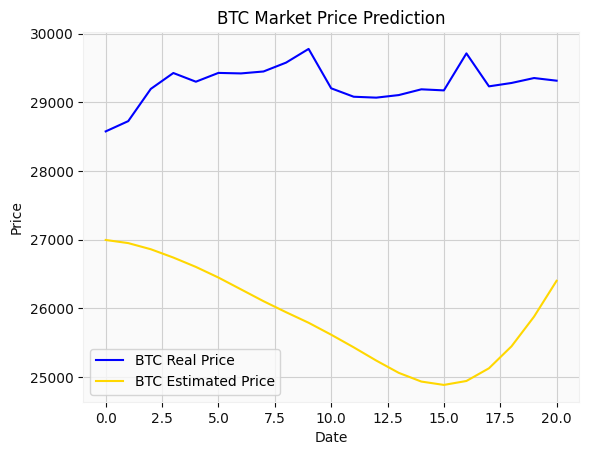


 Process is succeeded! Model results are in shown!


In [14]:
from myLSTMregressor import my_RNN_LSTM_Regressor as my_rnn
# x, y, test_num, pred_num, units=50, dropout=0.2, epoch=50, batch_size=32, predict=False, scaler=None
my_rnn_obj = my_rnn(
    X_scaled_df.sort_index(ascending=True),
    y_scaled_df.sort_index(ascending=True),
    test_num = 21,
    time_steps = 60,
    scaler = std_sc,
    epoch=25,
    predict=True,
    product = 'BTC'

)

## Prediction according to Close Price Only

In [14]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()

# Select the data that'll be used
y = df.iloc[:, 1:2]
X = df.iloc[:, 1:2]


X_scaled_array = std_sc.fit_transform(X.loc[:, ['Close']])

X_scaled_df = pd.DataFrame(X_scaled_array, columns = ['Close'], index = X.index)

y_scaled_array = std_sc.fit_transform(y.values.reshape(-1,1))
y_scaled_df = pd.DataFrame(y_scaled_array, columns=y.columns, index=y.index)

Processing: Train-Test Split...
Processing: Seperate Train Data to X and Y according to Time Steps...
Model is building...
Model is running...
Epoch 1/20
52/52 [==============================] - 15s 104ms/step - loss: 0.1634
Epoch 2/20
52/52 [==============================] - 5s 104ms/step - loss: 0.0475
Epoch 3/20
52/52 [==============================] - 6s 108ms/step - loss: 0.0457
Epoch 4/20
52/52 [==============================] - 8s 145ms/step - loss: 0.0451
Epoch 5/20
52/52 [==============================] - 5s 94ms/step - loss: 0.0378
Epoch 6/20
52/52 [==============================] - 5s 99ms/step - loss: 0.0364
Epoch 7/20
52/52 [==============================] - 6s 121ms/step - loss: 0.0295
Epoch 8/20
52/52 [==============================] - 7s 132ms/step - loss: 0.0336
Epoch 9/20
52/52 [==============================] - 10s 192ms/step - loss: 0.0270
Epoch 10/20
52/52 [==============================] - 9s 166ms/step - loss: 0.0267
Epoch 11/20
52/52 [===========================

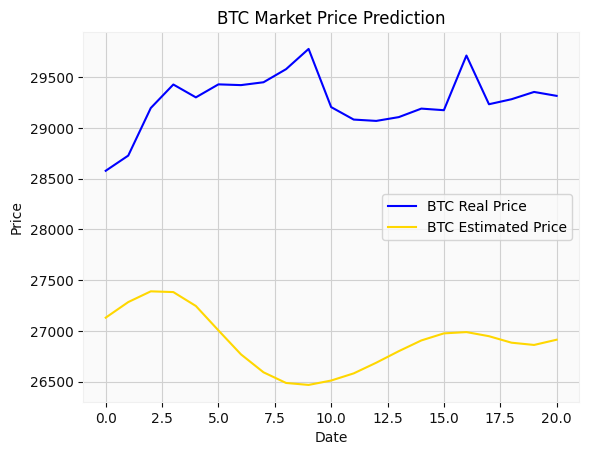


 Process is succeeded! Model results are in shown!


In [15]:
from myLSTMregressor import my_RNN_LSTM_Regressor as my_rnn
# x, y, test_num, pred_num, units=50, dropout=0.2, epoch=50, batch_size=32, predict=False, scaler=None
my_rnn_obj = my_rnn(
    X_scaled_df.sort_index(ascending=True),
    y_scaled_df.sort_index(ascending=True),
    test_num = 21,
    time_steps = 60,
    scaler = std_sc,
    epoch=2,
    predict=True,
    product = 'BTC'

    
)